In [57]:
import pandas as pd
import torch
from typing import Dict,List
from sklearn.model_selection import train_test_split
import torch.nn as nn
import flwr as fl
from flwr.common import Metrics
from collections import OrderedDict
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset,random_split
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [59]:
df = pd.read_csv("survey_lung_cancer.csv")
df.head(7)

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO
5,F,75,1,2,1,1,2,2,2,2,1,2,2,1,1,YES
6,M,52,2,1,1,1,1,2,1,2,2,2,2,1,2,YES


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 309 non-null    object
 1   AGE                    309 non-null    int64 
 2   SMOKING                309 non-null    int64 
 3   YELLOW_FINGERS         309 non-null    int64 
 4   ANXIETY                309 non-null    int64 
 5   PEER_PRESSURE          309 non-null    int64 
 6   CHRONIC DISEASE        309 non-null    int64 
 7   FATIGUE                309 non-null    int64 
 8   ALLERGY                309 non-null    int64 
 9   WHEEZING               309 non-null    int64 
 10  ALCOHOL CONSUMING      309 non-null    int64 
 11  COUGHING               309 non-null    int64 
 12  SHORTNESS OF BREATH    309 non-null    int64 
 13  SWALLOWING DIFFICULTY  309 non-null    int64 
 14  CHEST PAIN             309 non-null    int64 
 15  LUNG_CANCER            

In [61]:
df.describe()

,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,62.673139,1.563107,1.569579,1.498382,1.501618,1.504854,1.673139,1.556634,1.556634,1.556634,1.579288,1.640777,1.469256,1.556634
std,8.210301,0.496806,0.495938,0.500808,0.500808,0.500787,0.469827,0.497588,0.497588,0.497588,0.494474,0.480551,0.499863,0.497588
min,21.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,57.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,62.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000
75%,69.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,87.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [62]:
df.all().isna()

GENDER                   False
AGE                      False
SMOKING                  False
YELLOW_FINGERS           False
ANXIETY                  False
PEER_PRESSURE            False
CHRONIC DISEASE          False
FATIGUE                  False
ALLERGY                  False
WHEEZING                 False
ALCOHOL CONSUMING        False
COUGHING                 False
SHORTNESS OF BREATH      False
SWALLOWING DIFFICULTY    False
CHEST PAIN               False
LUNG_CANCER              False
dtype: bool

In [63]:
sex_map = {'M' : 0, 'F' : 1}
cancer_map = {'YES':1,'NO':0}

In [64]:
df['GENDER'] = df['GENDER'].apply(lambda X: sex_map[X])
df['LUNG_CANCER'] = df['LUNG_CANCER'].apply(lambda X: cancer_map[X])

C:\Users\nasaa\AppData\Local\Temp\ipykernel_41360\982672209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = i, data = df,


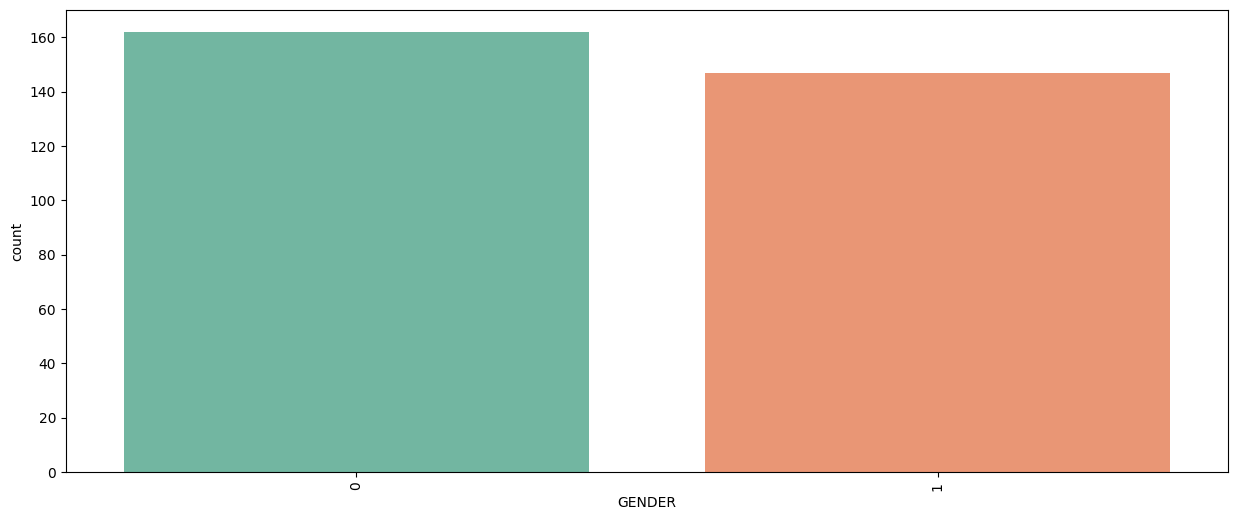

C:\Users\nasaa\AppData\Local\Temp\ipykernel_41360\982672209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = i, data = df,


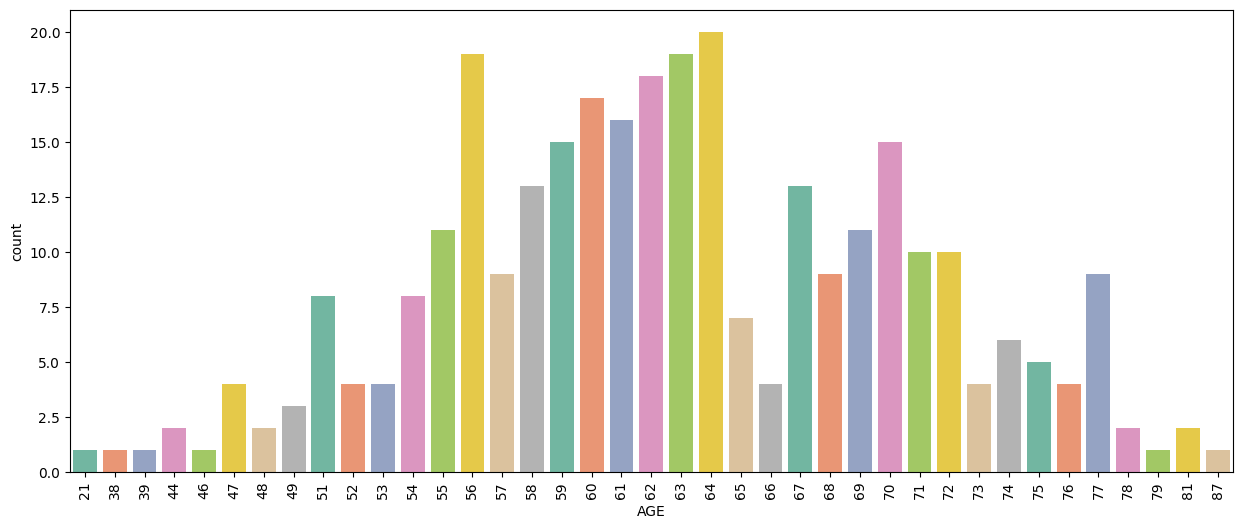

C:\Users\nasaa\AppData\Local\Temp\ipykernel_41360\982672209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = i, data = df,


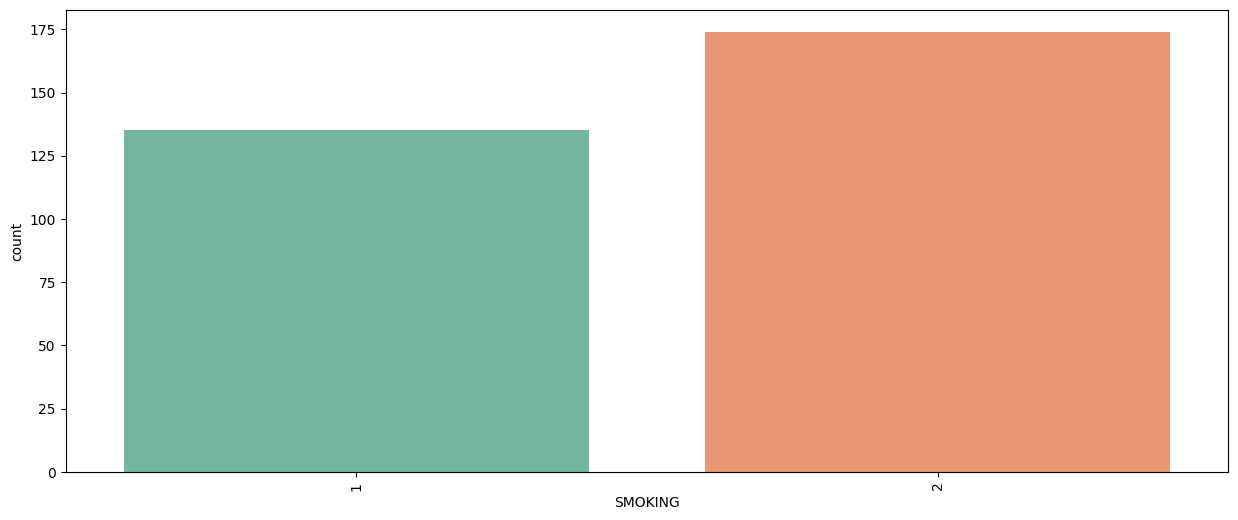

C:\Users\nasaa\AppData\Local\Temp\ipykernel_41360\982672209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = i, data = df,


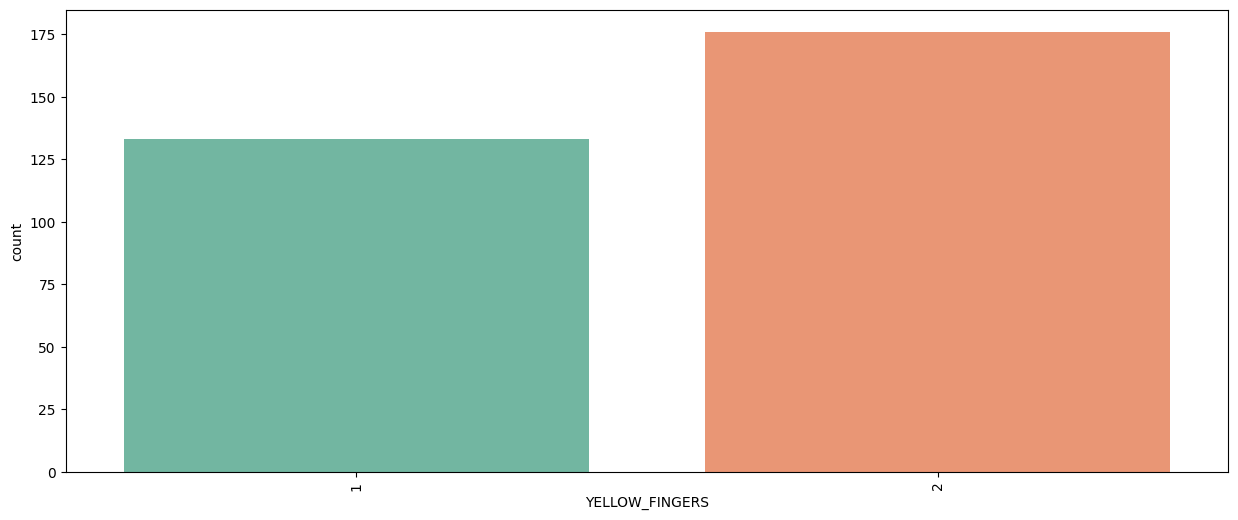

C:\Users\nasaa\AppData\Local\Temp\ipykernel_41360\982672209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = i, data = df,


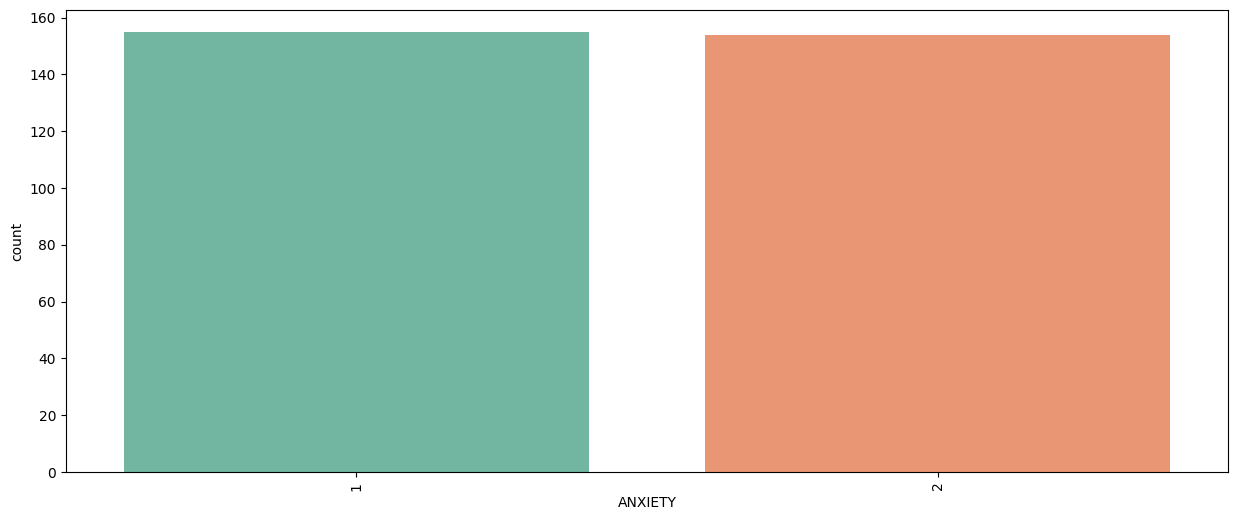

C:\Users\nasaa\AppData\Local\Temp\ipykernel_41360\982672209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = i, data = df,


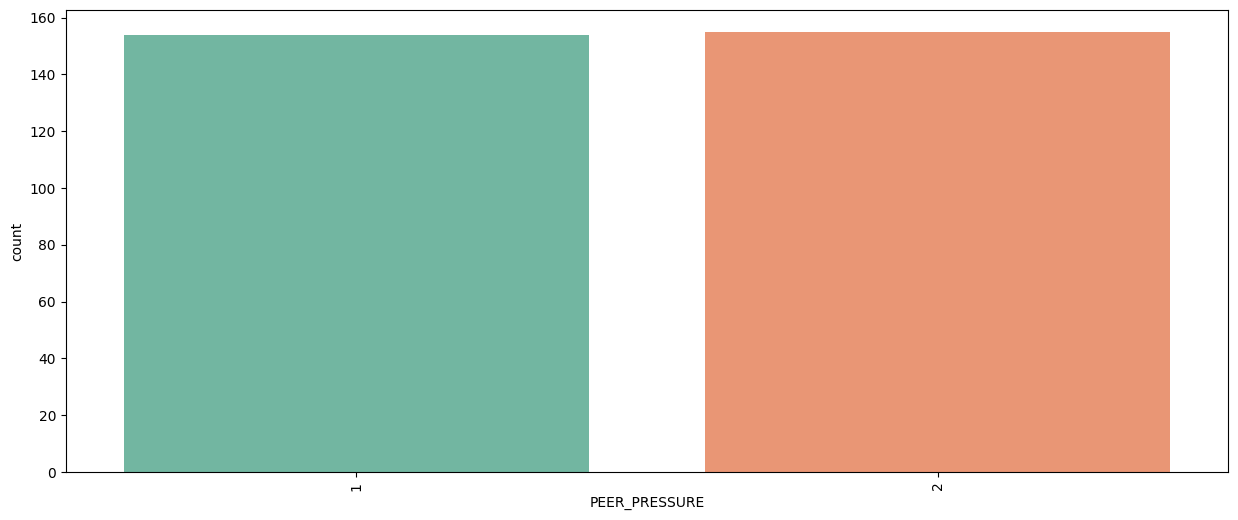

C:\Users\nasaa\AppData\Local\Temp\ipykernel_41360\982672209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = i, data = df,


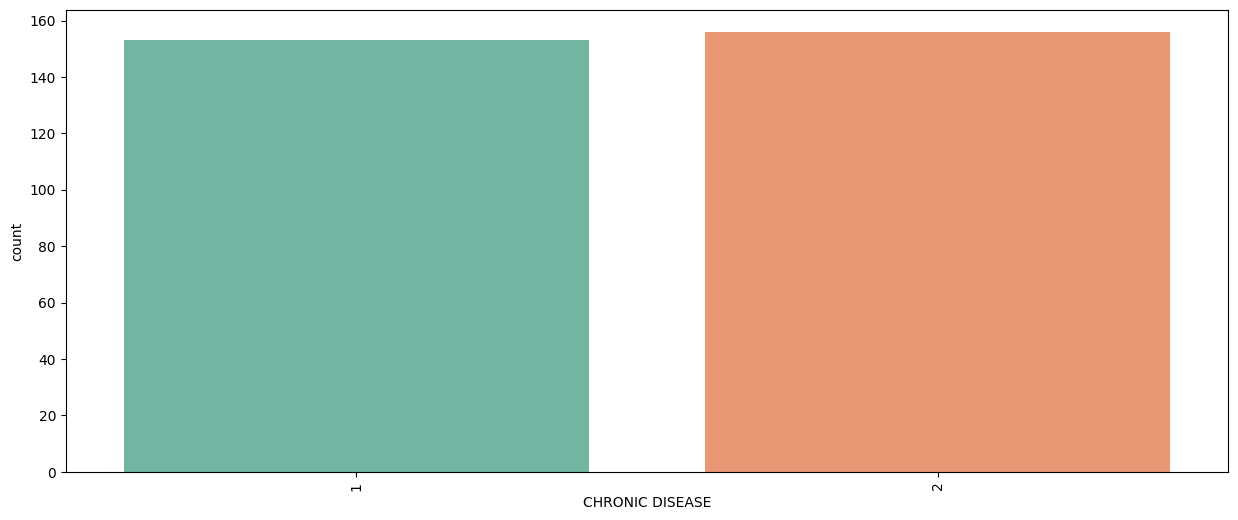

C:\Users\nasaa\AppData\Local\Temp\ipykernel_41360\982672209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = i, data = df,


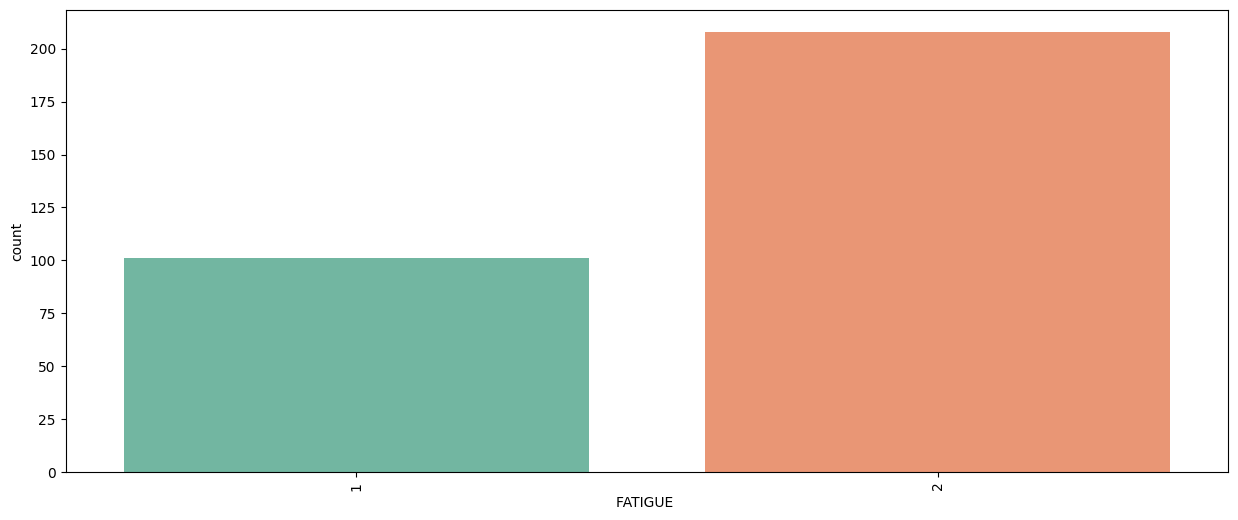

C:\Users\nasaa\AppData\Local\Temp\ipykernel_41360\982672209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = i, data = df,


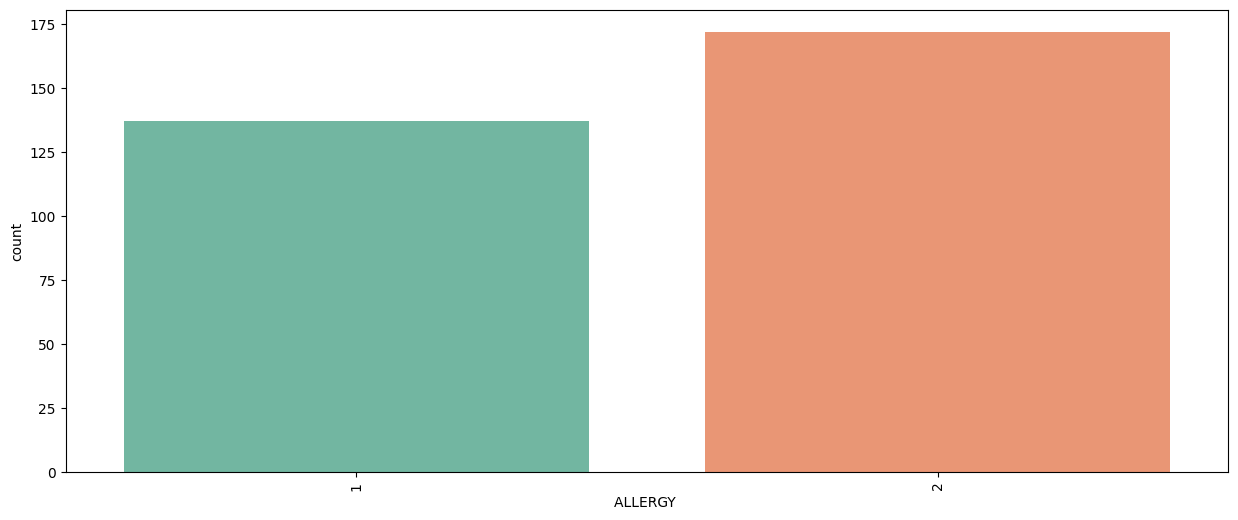

C:\Users\nasaa\AppData\Local\Temp\ipykernel_41360\982672209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = i, data = df,


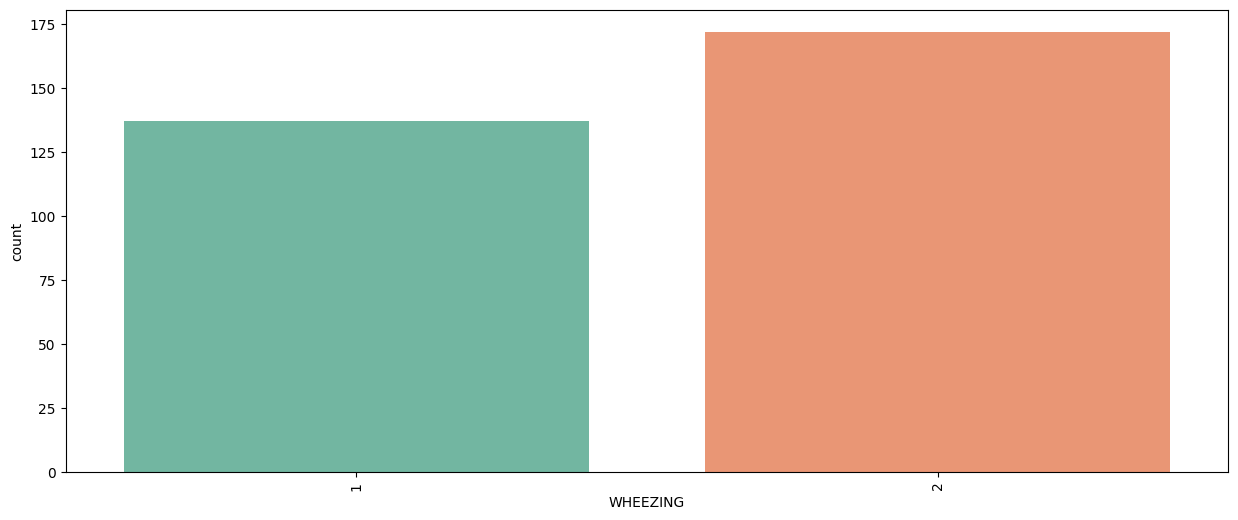

C:\Users\nasaa\AppData\Local\Temp\ipykernel_41360\982672209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = i, data = df,


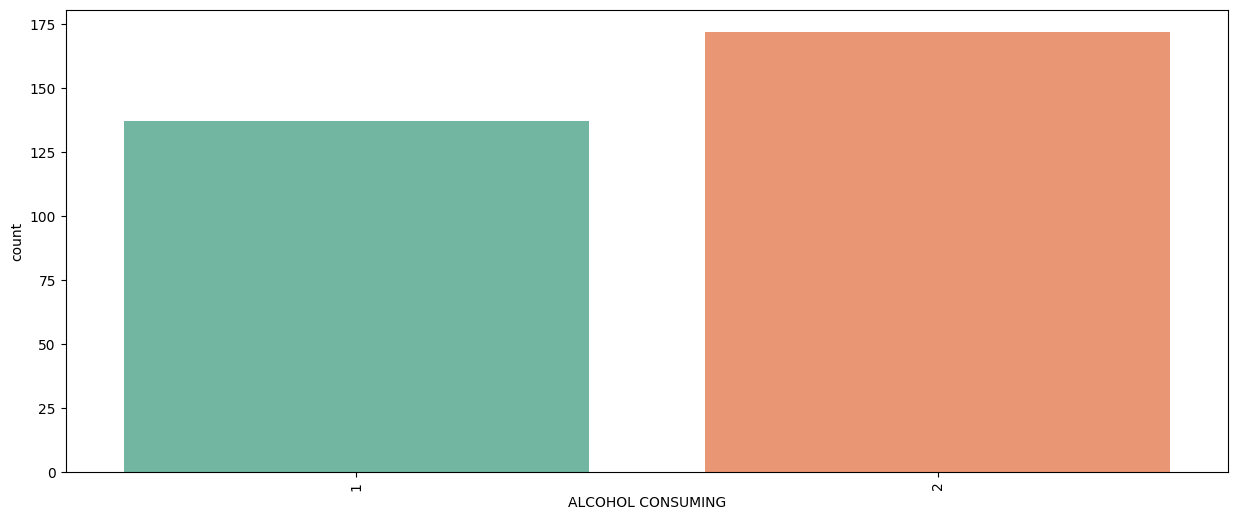

C:\Users\nasaa\AppData\Local\Temp\ipykernel_41360\982672209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = i, data = df,


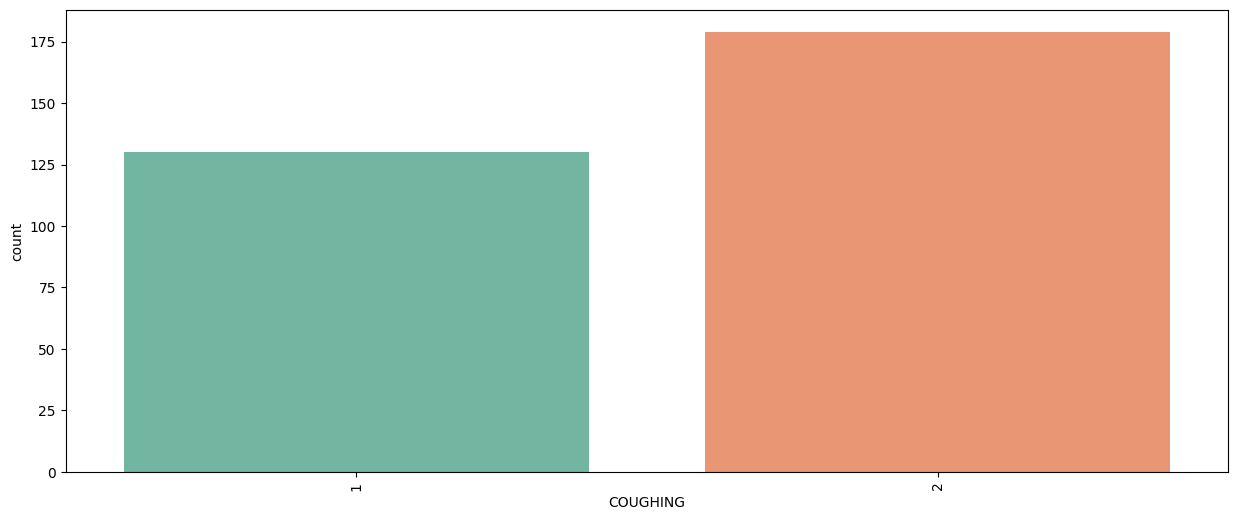

C:\Users\nasaa\AppData\Local\Temp\ipykernel_41360\982672209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = i, data = df,


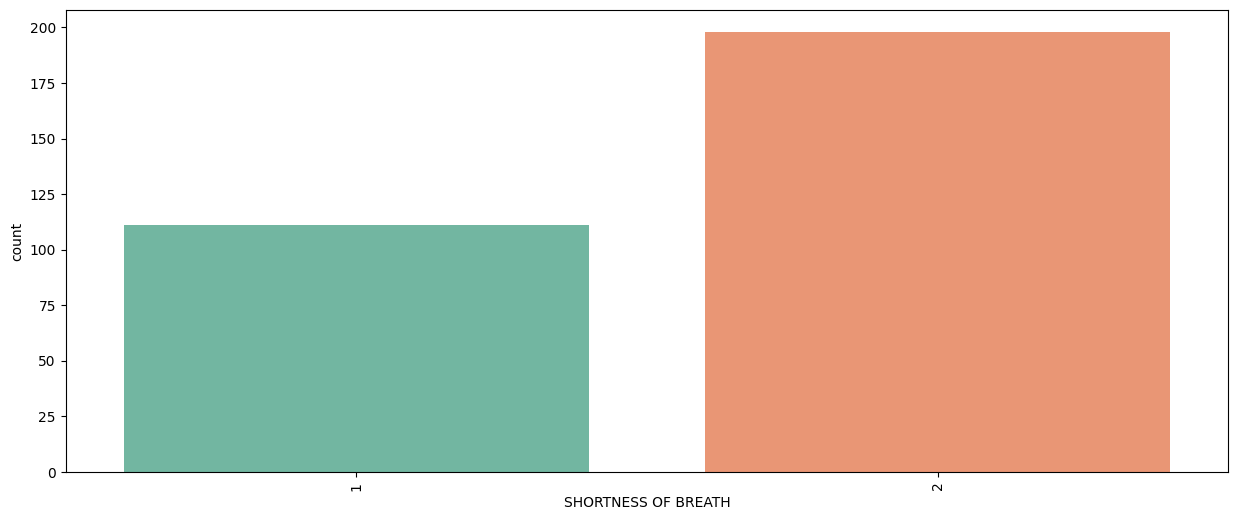

C:\Users\nasaa\AppData\Local\Temp\ipykernel_41360\982672209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = i, data = df,


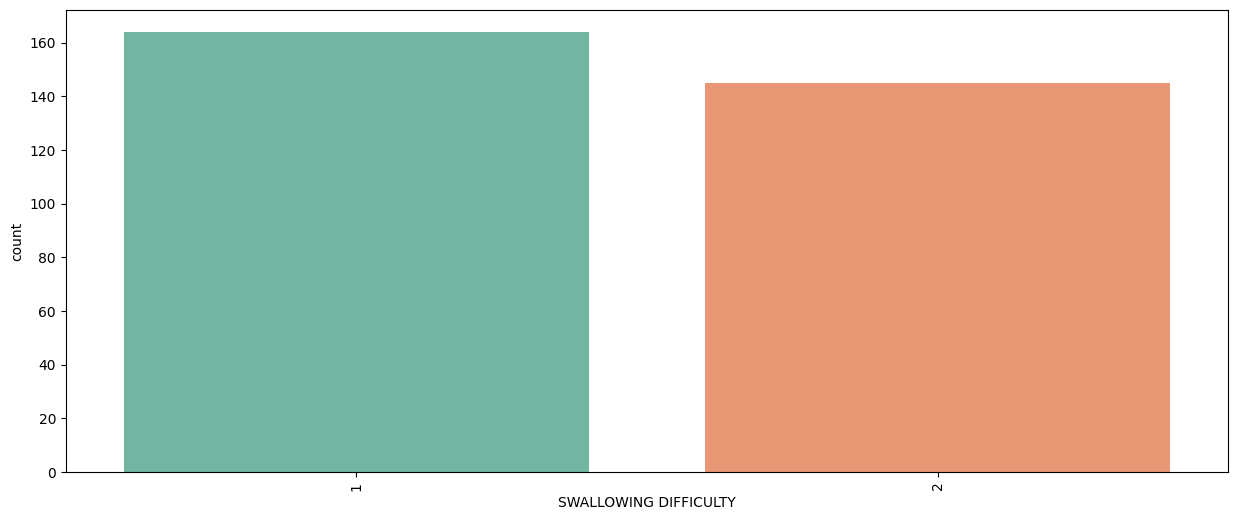

C:\Users\nasaa\AppData\Local\Temp\ipykernel_41360\982672209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = i, data = df,


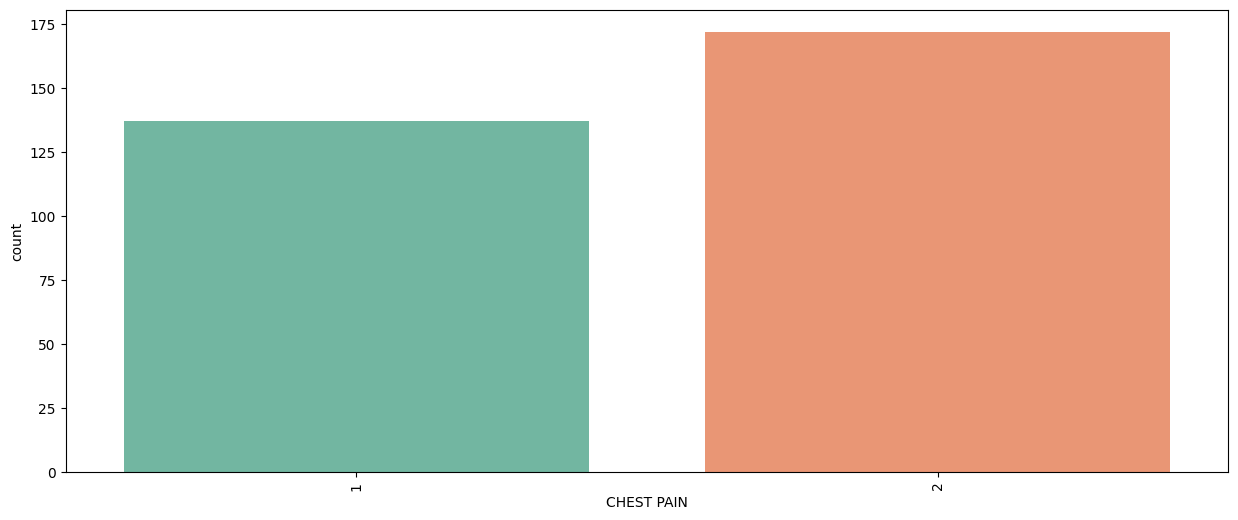

C:\Users\nasaa\AppData\Local\Temp\ipykernel_41360\982672209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = i, data = df,


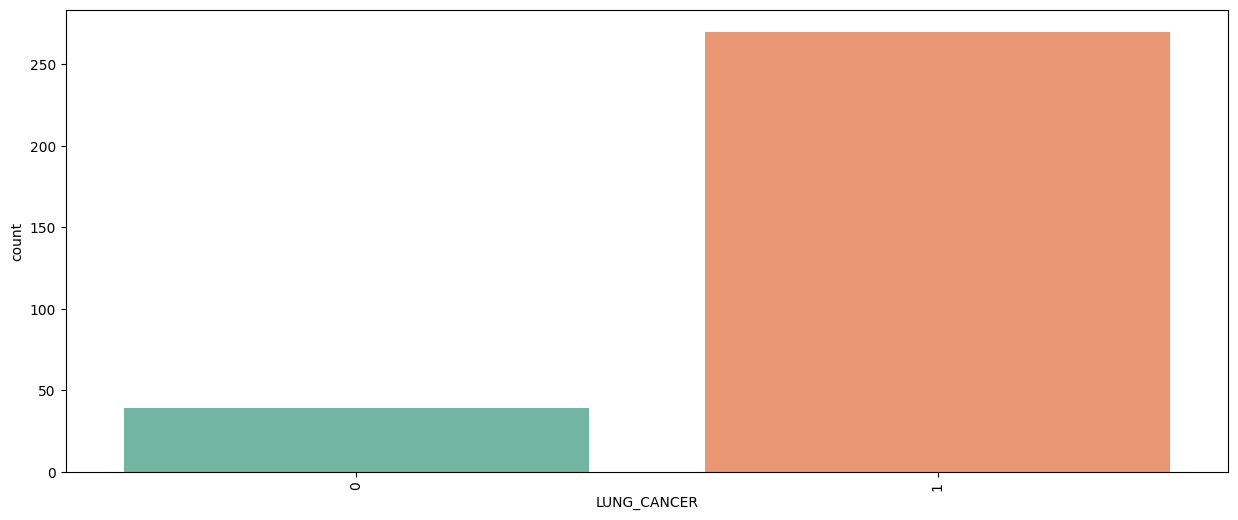

In [65]:
for i in df.columns:
    plt.figure(figsize = (15,6))
    sns.countplot(x = i, data = df,
    palette='Set2')
    plt.xticks(rotation = 90)
    plt.show()

C:\Users\nasaa\AppData\Local\Temp\ipykernel_41360\1551821595.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x = df[i], color='red', kde = True)
C:\Users\nasaa\AppData\Local\Temp\ipykernel_41360\1551821595.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x = df[i], color='red', kde = True

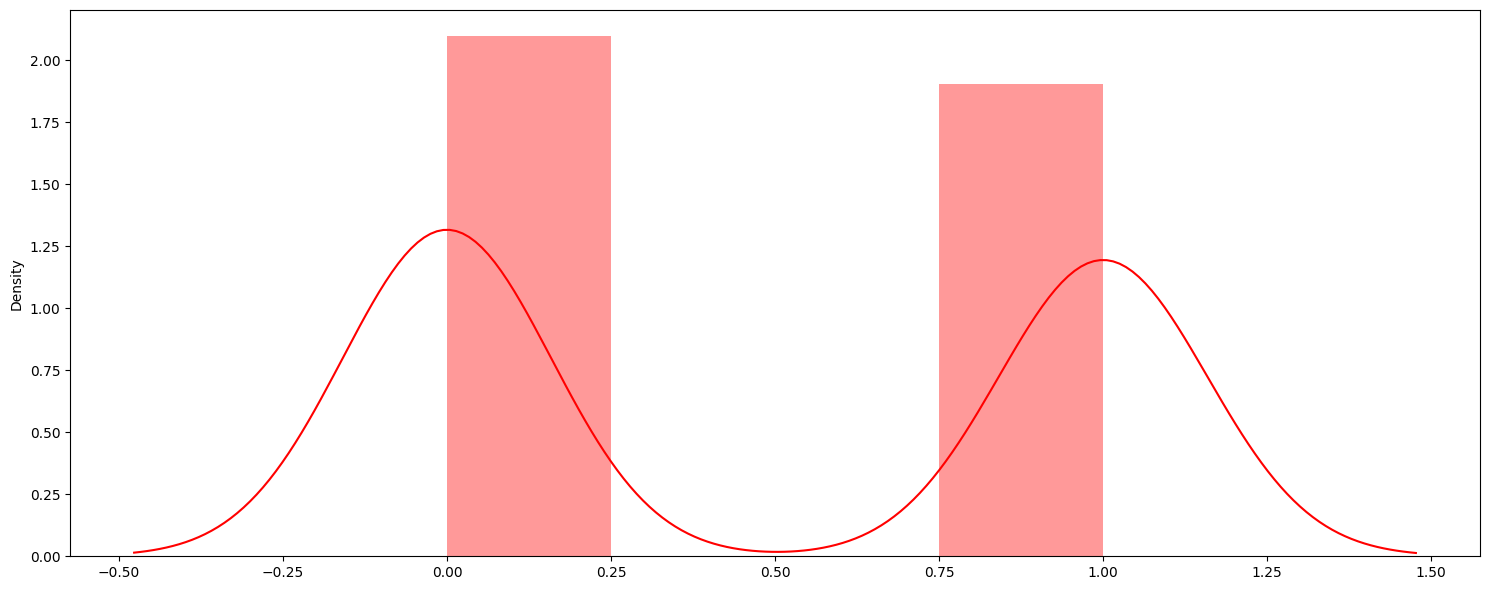

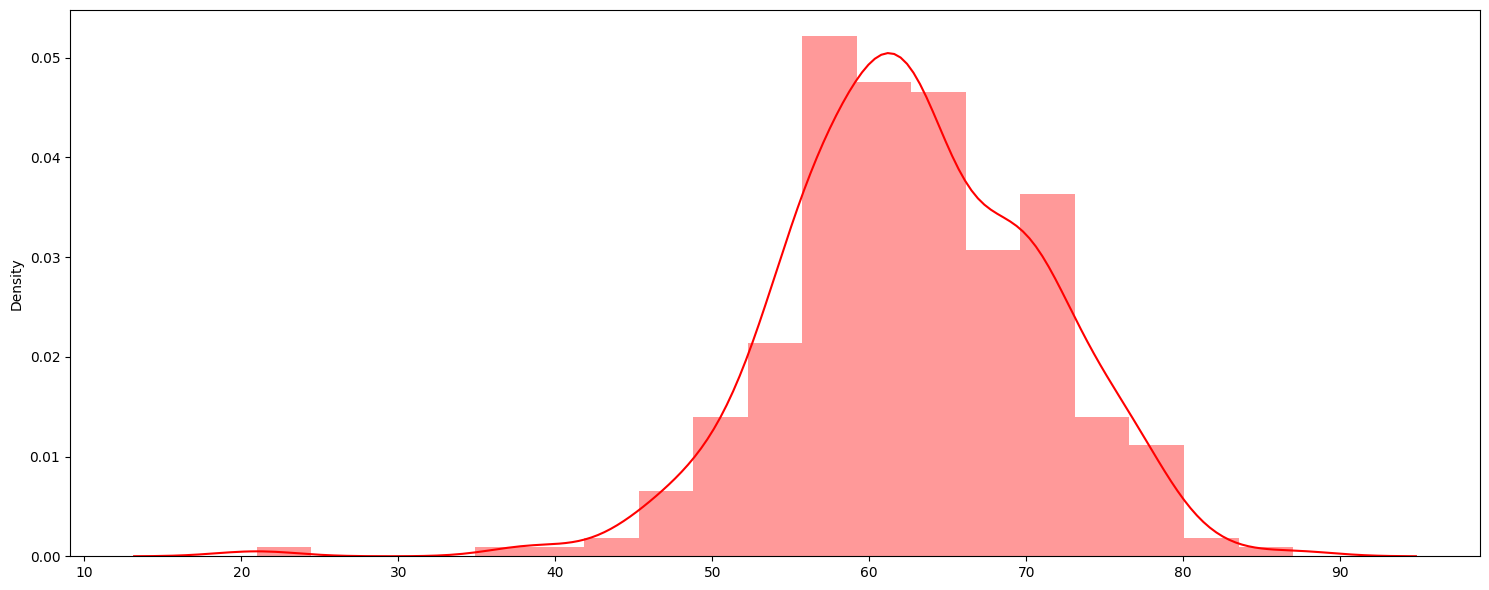

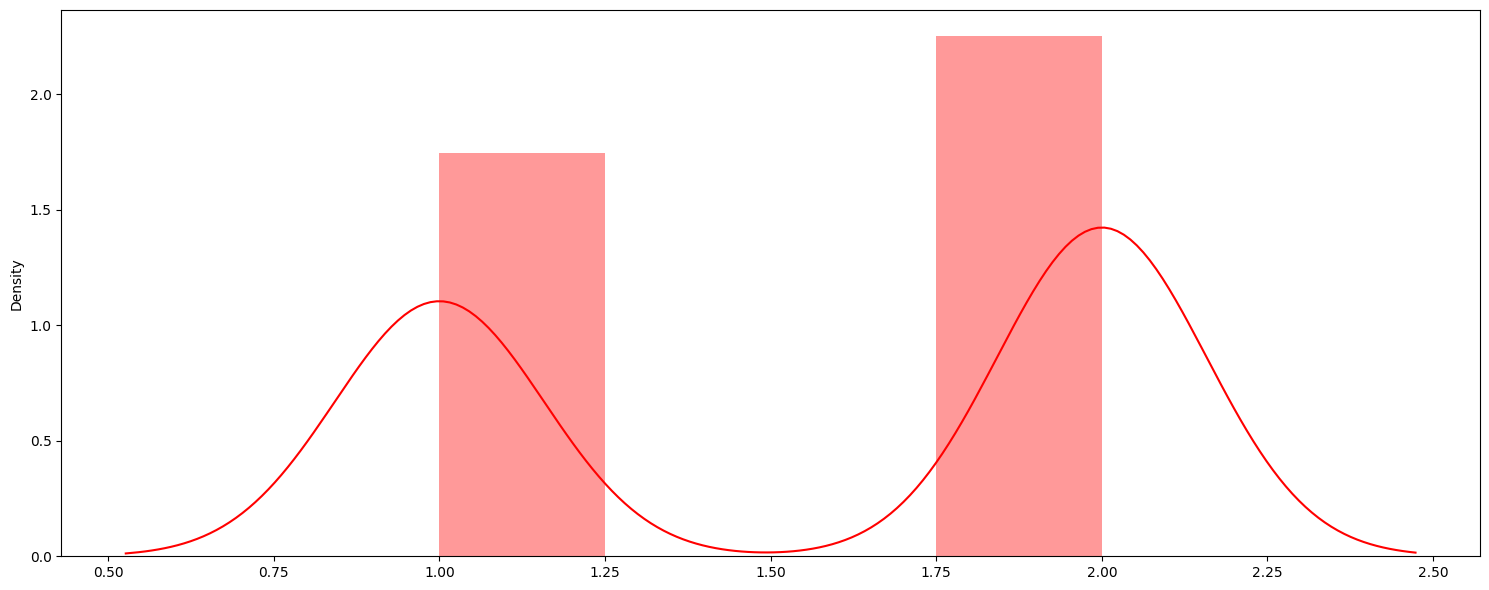

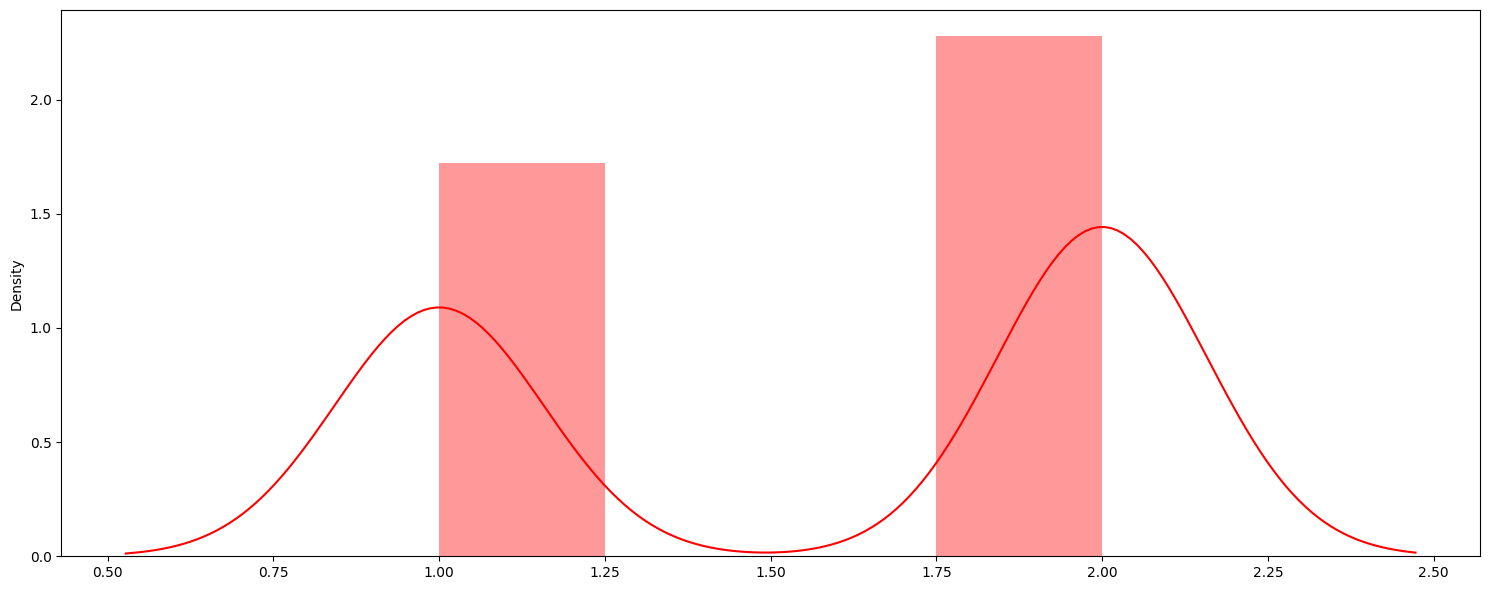

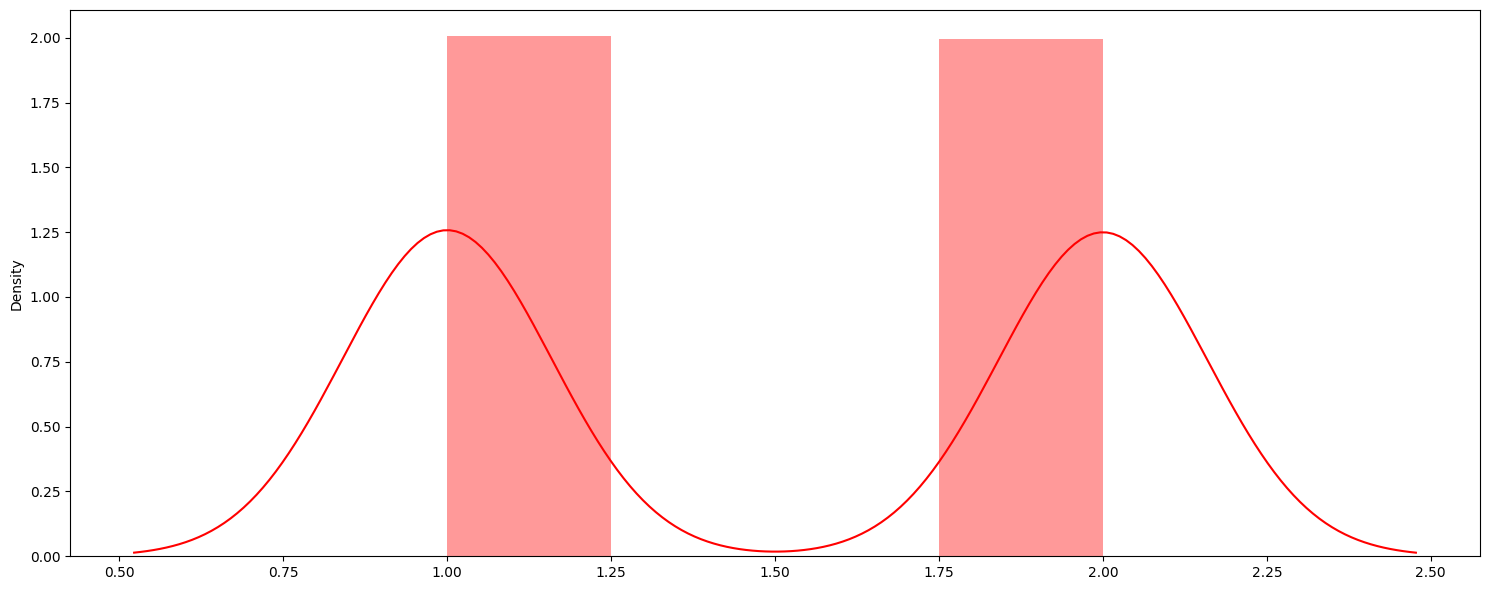

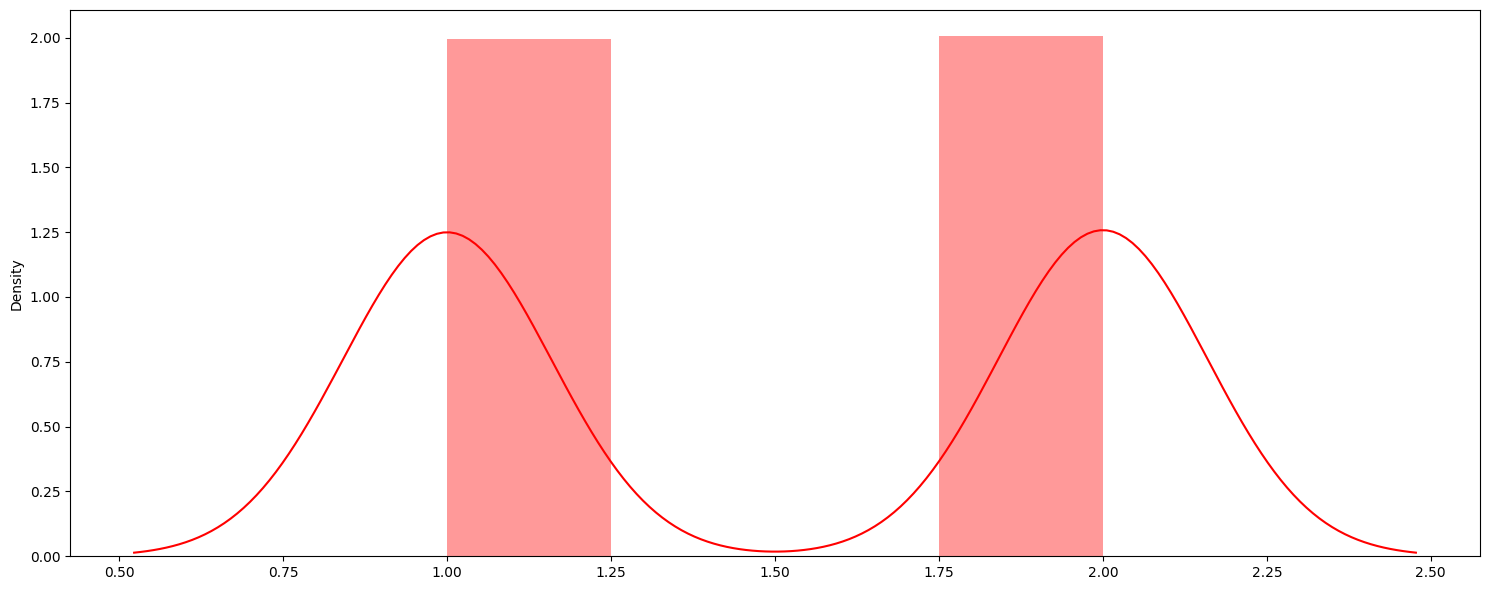

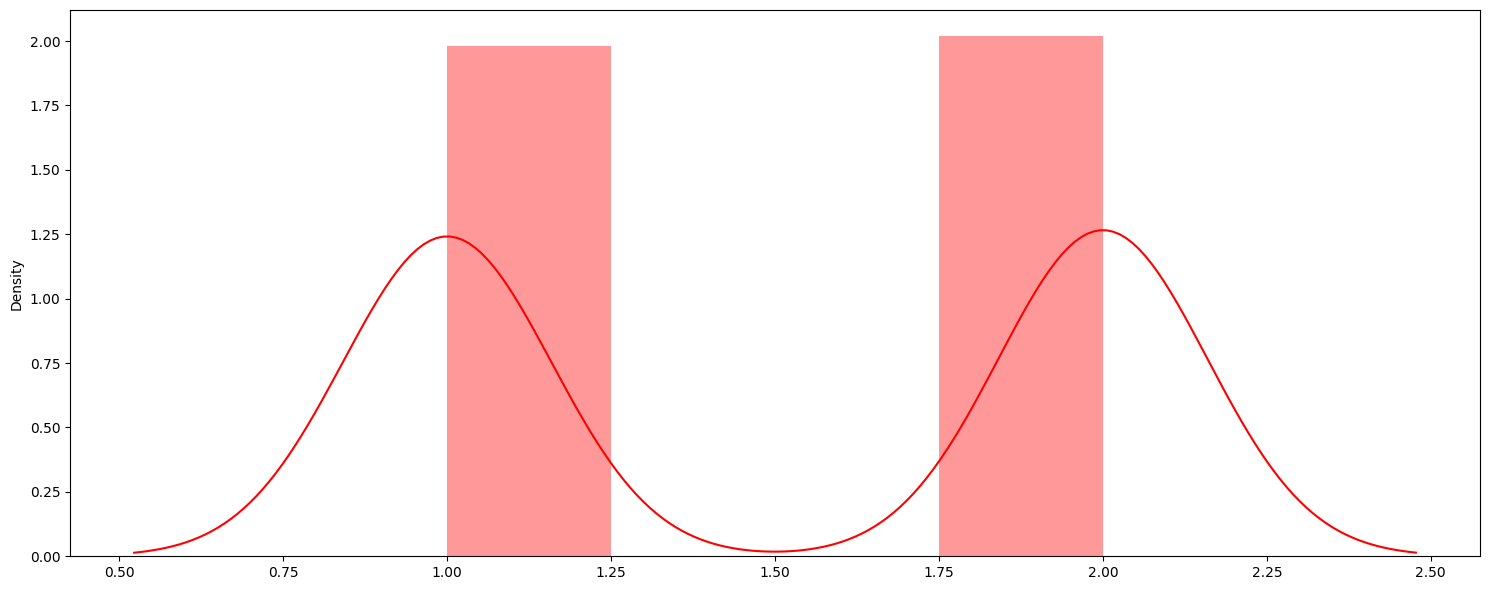

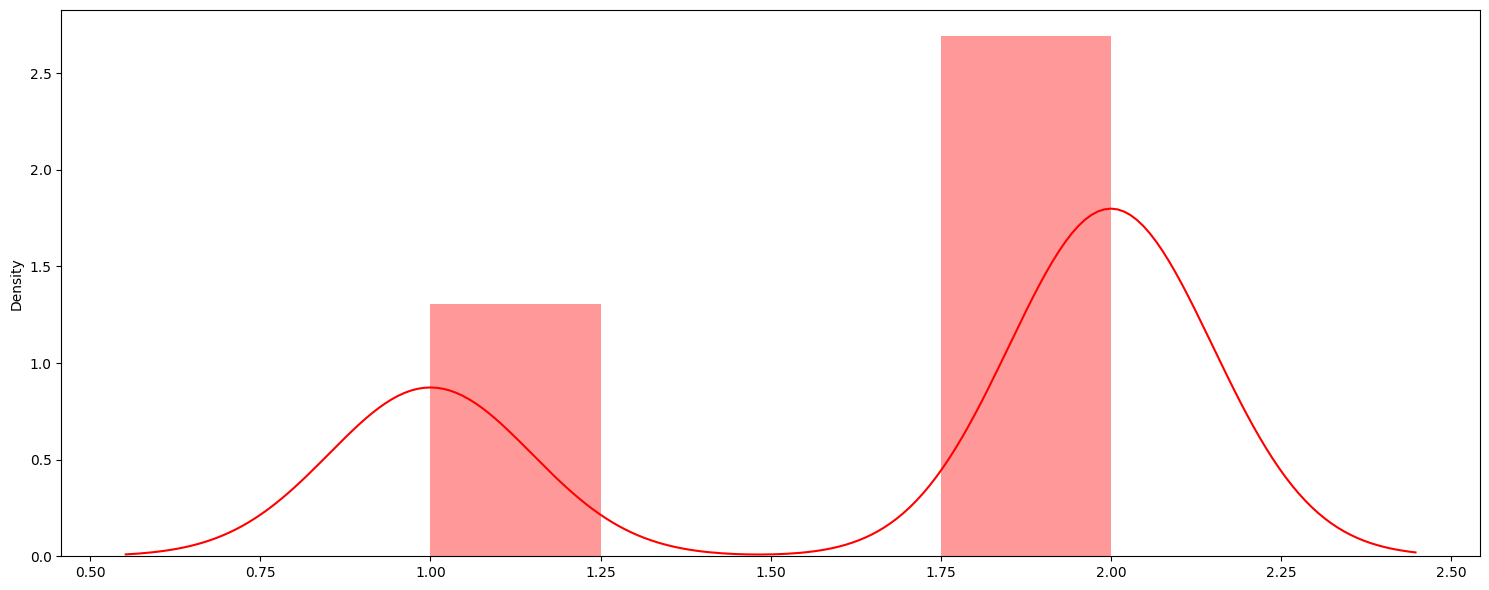

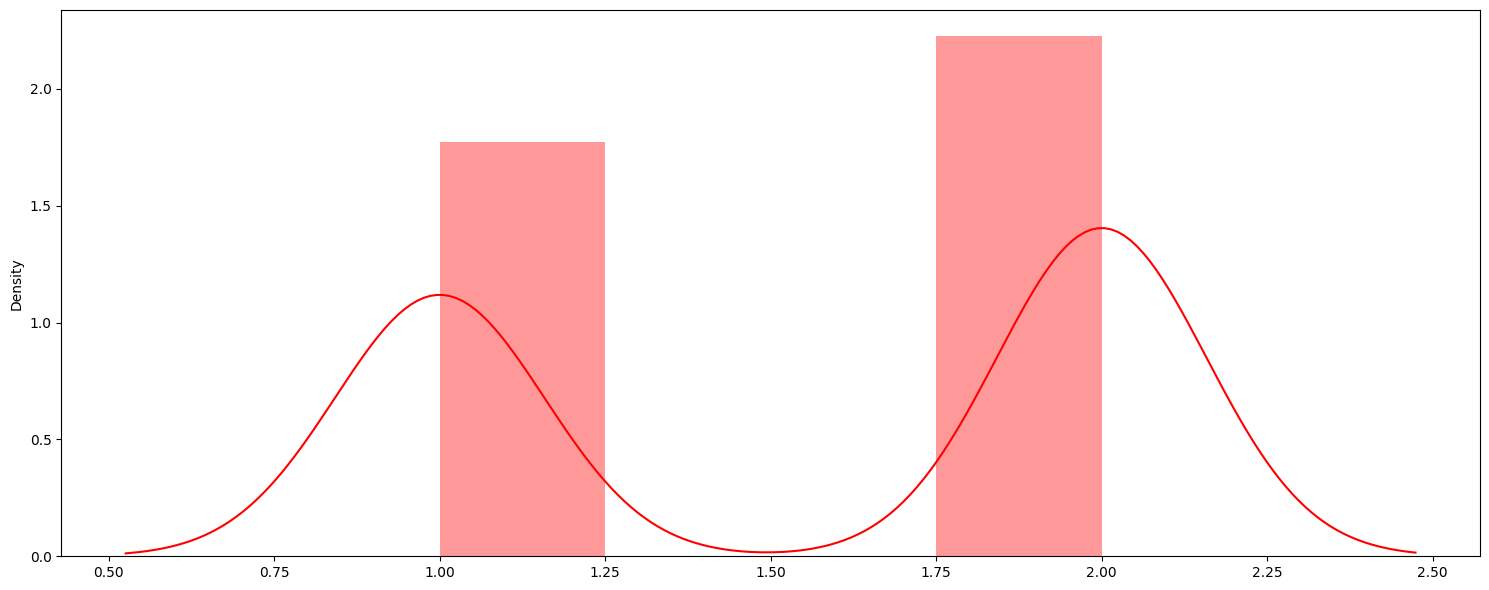

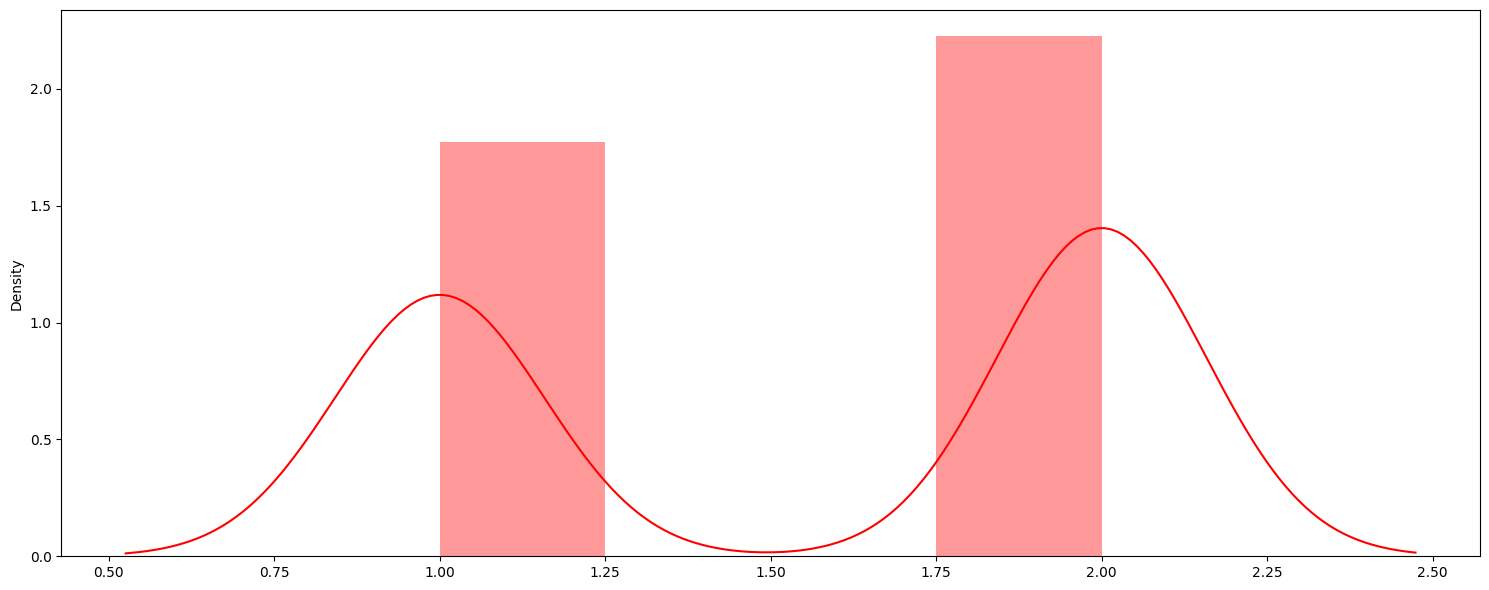

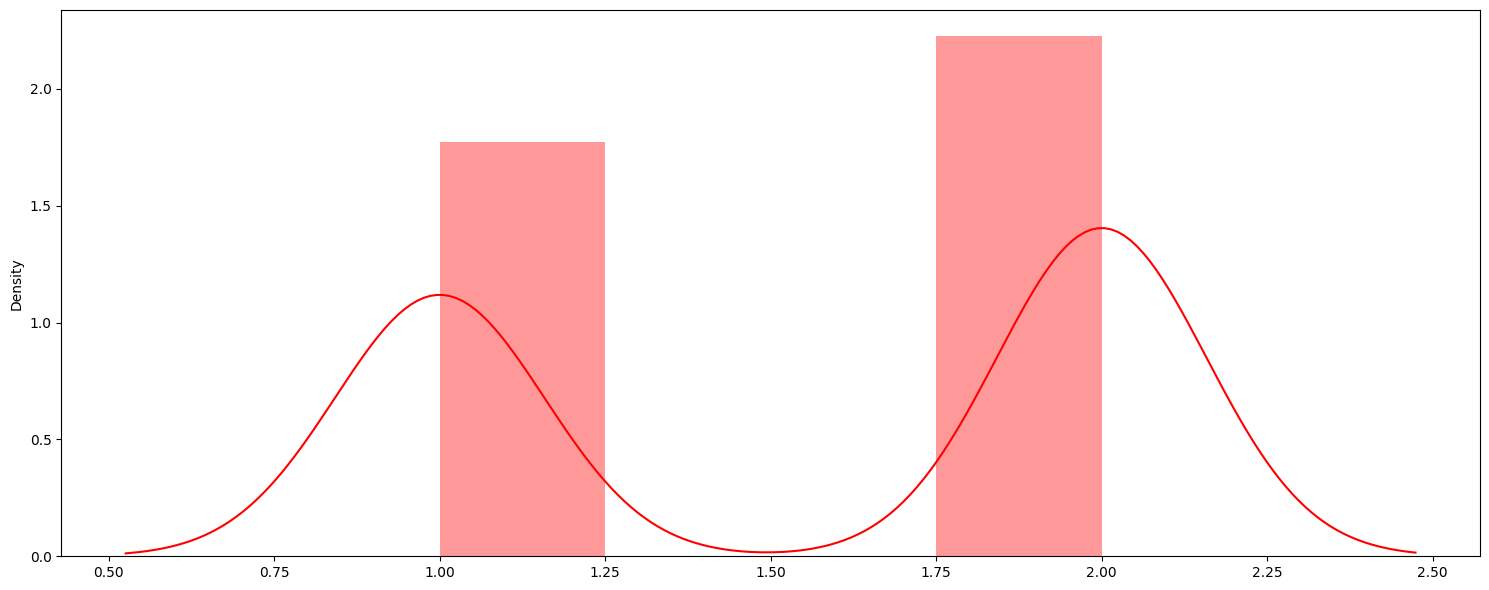

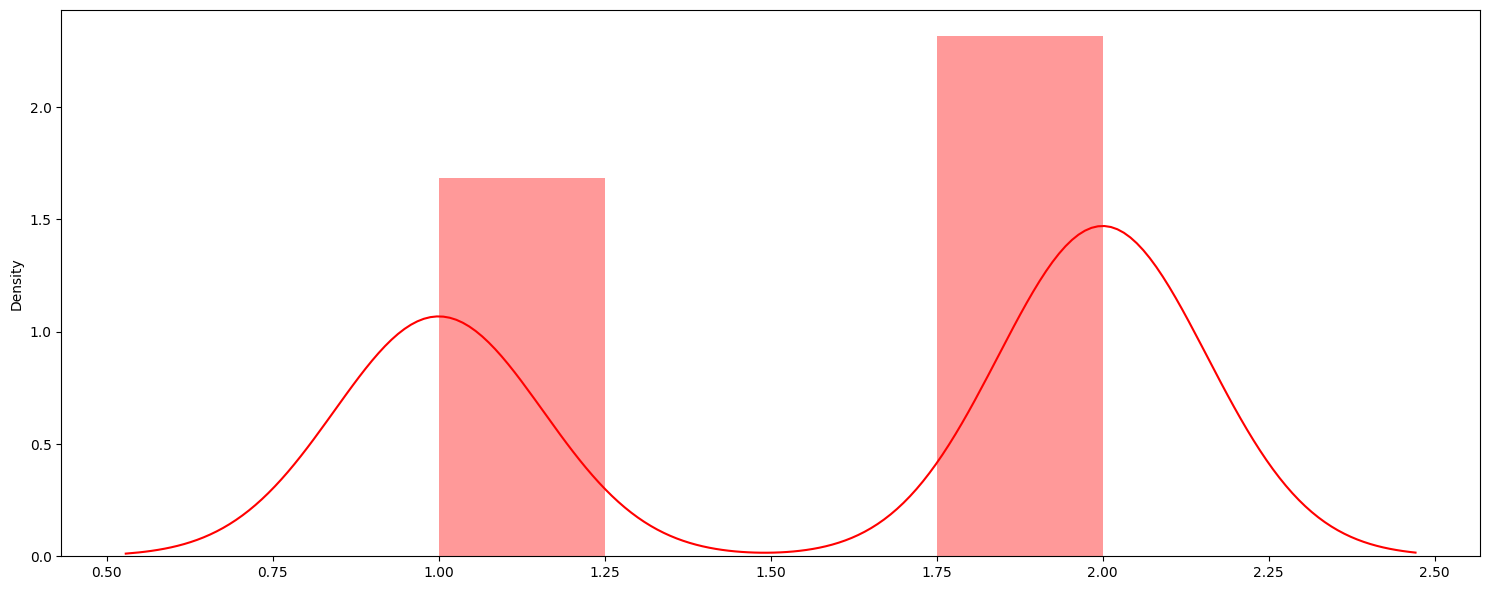

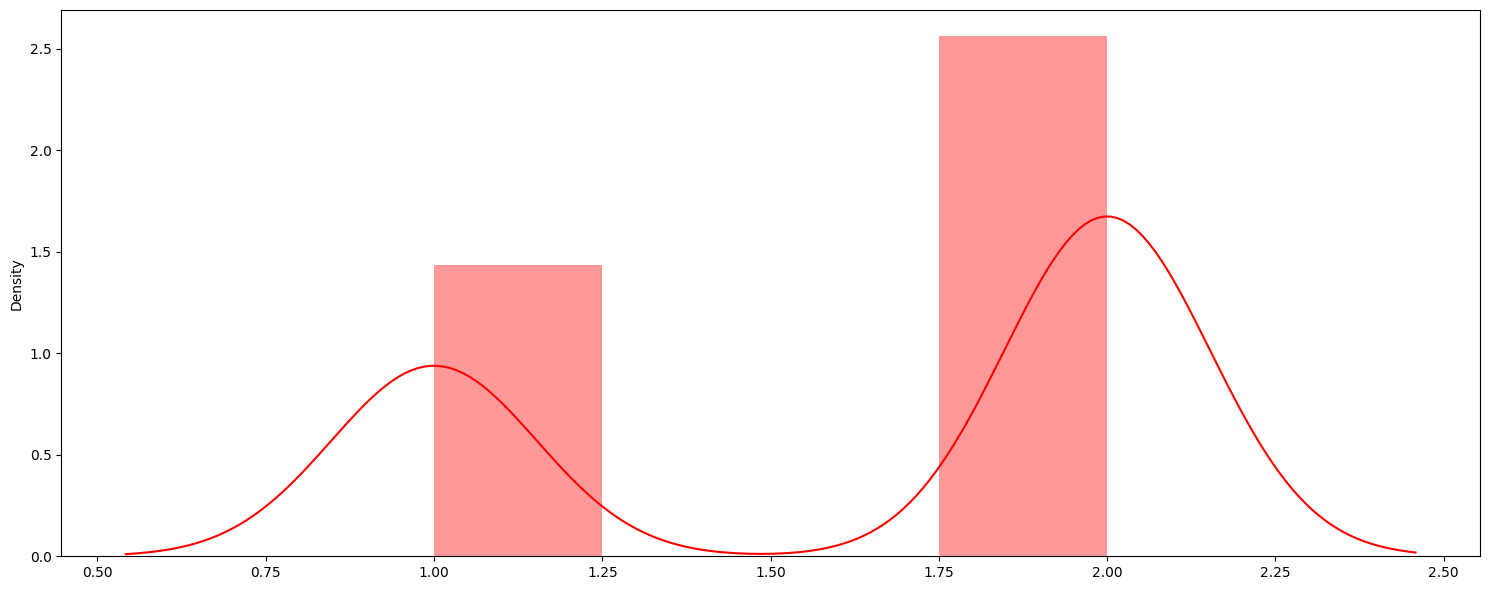

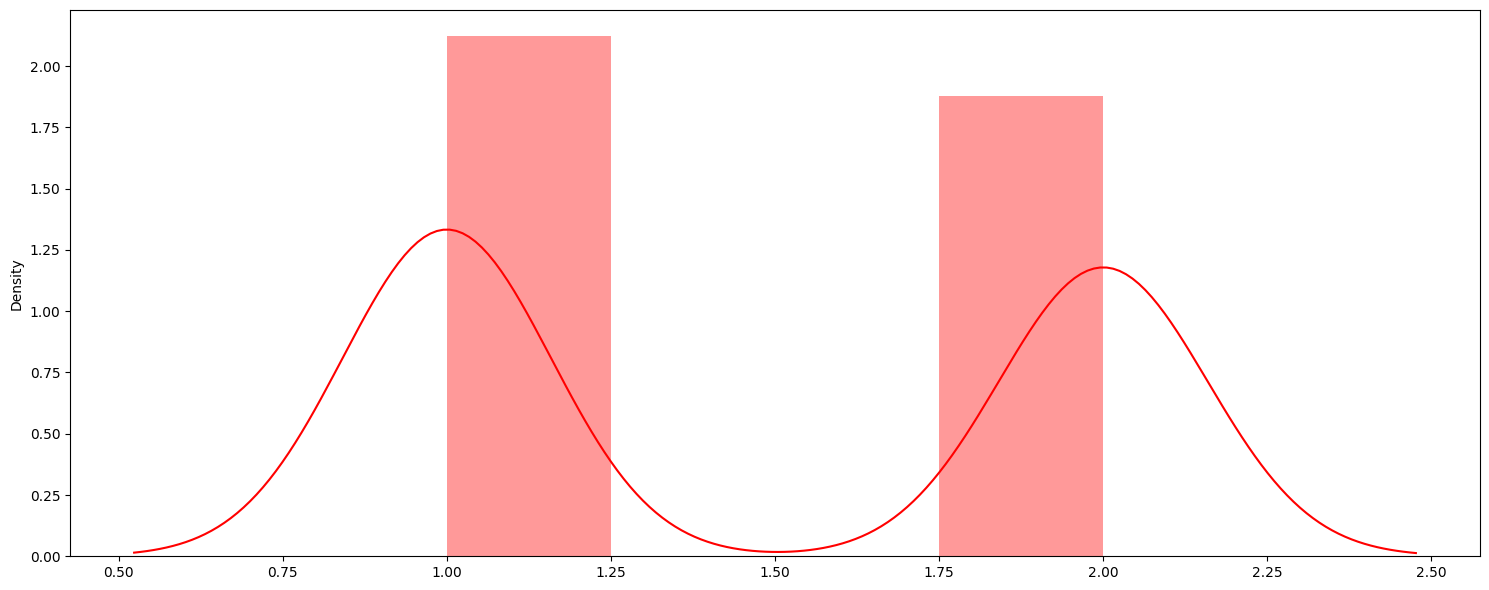

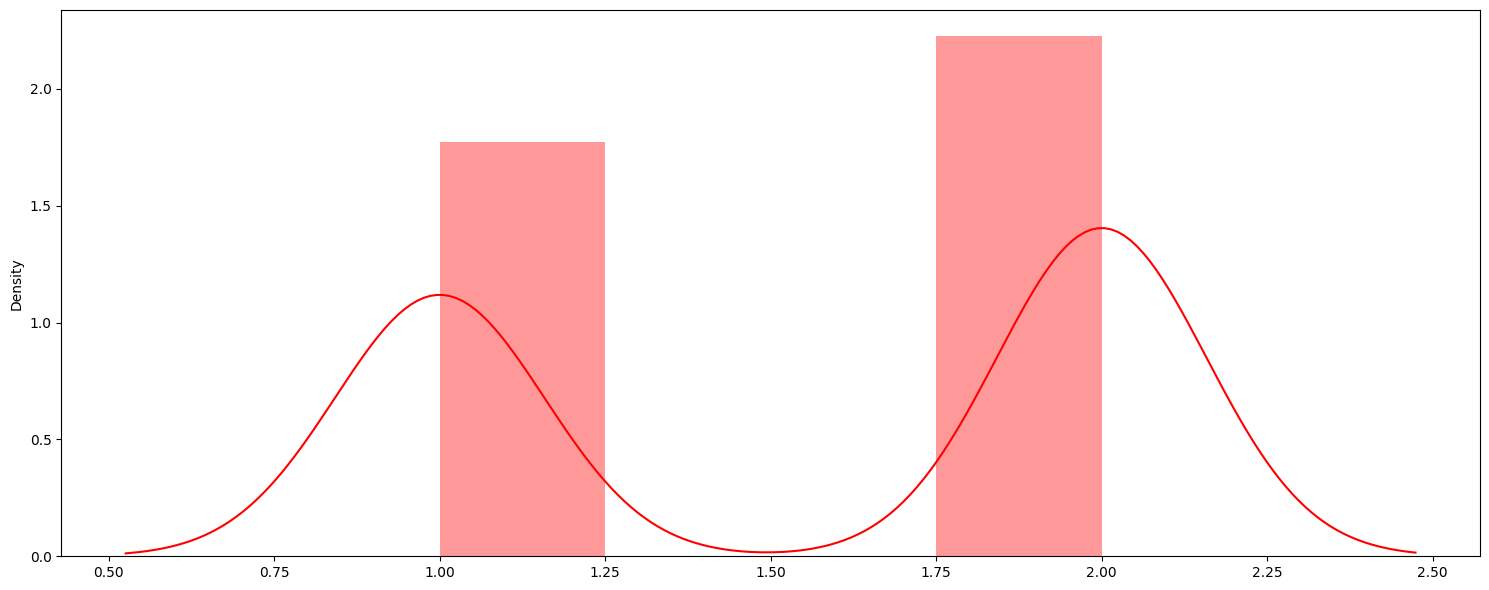

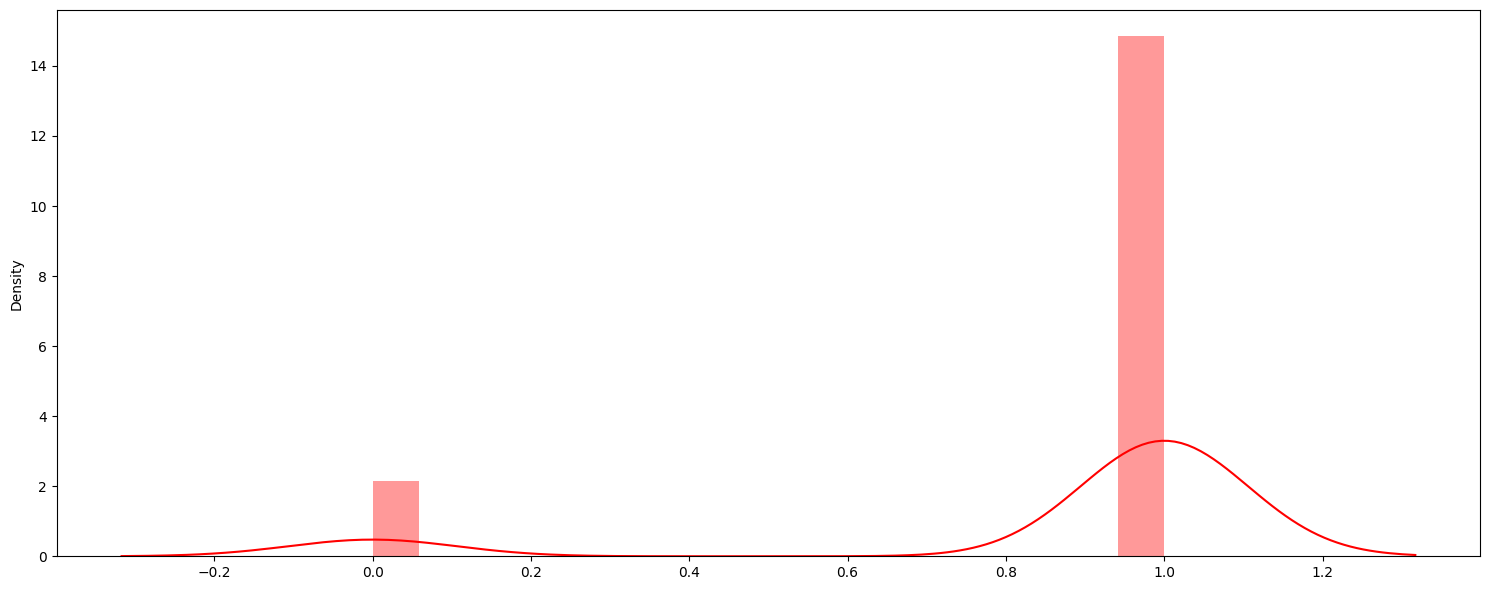

In [66]:
for i in df.columns:
    plt.figure(figsize=(15,6))
    sns.distplot(x = df[i], color='red', kde = True)
    plt.tight_layout()

<Axes: >

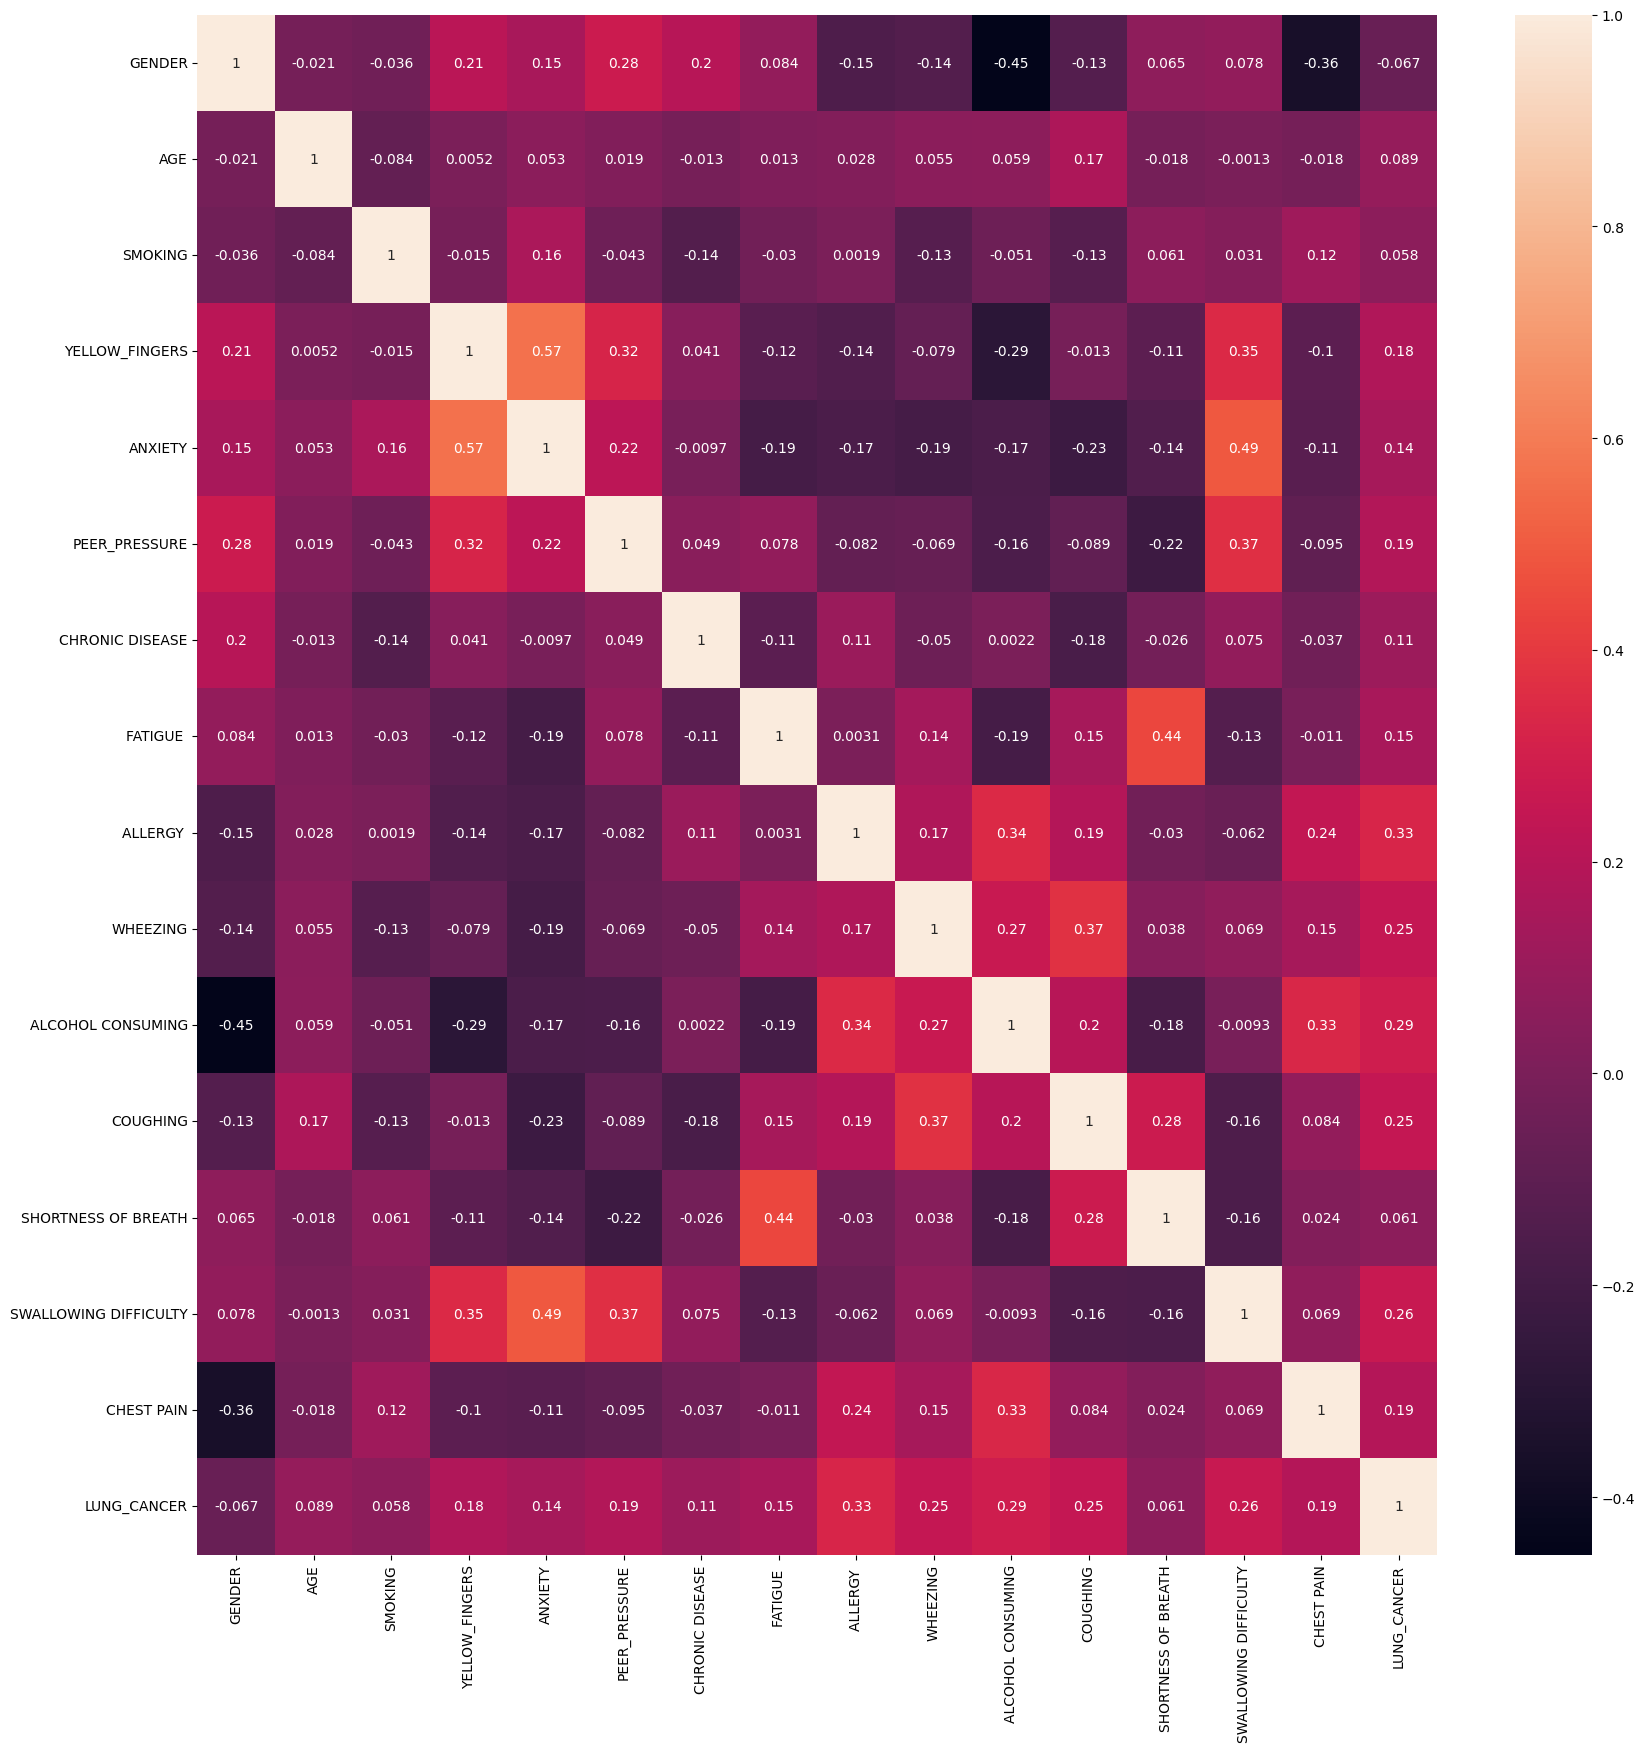

In [67]:
plt.figure(figsize = (20,20))
sns.heatmap(df.corr(), annot = True)

In [68]:
df.keys()

Index(['GENDER', 'AGE', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY',
       'PEER_PRESSURE', 'CHRONIC DISEASE', 'FATIGUE ', 'ALLERGY ', 'WHEEZING',
       'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
       'SWALLOWING DIFFICULTY', 'CHEST PAIN', 'LUNG_CANCER'],
      dtype='object')

In [84]:
a = df.iloc[:, :-1]

In [85]:
a

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN
0,0,69,1,2,2,1,1,2,1,2,2,2,2,2,2
1,0,74,2,1,1,1,2,2,2,1,1,1,2,2,2
2,1,59,1,1,1,2,1,2,1,2,1,2,2,1,2
3,0,63,2,2,2,1,1,1,1,1,2,1,1,2,2
4,1,63,1,2,1,1,1,1,1,2,1,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,1,56,1,1,1,2,2,2,1,1,2,2,2,2,1
305,0,70,2,1,1,1,1,2,2,2,2,2,2,1,2
306,0,58,2,1,1,1,1,1,2,2,2,2,1,1,2
307,0,67,2,1,2,1,1,2,2,1,2,2,2,1,2


In [86]:
y = df.iloc[:, -1]

In [87]:
y

0      1
1      1
2      0
3      0
4      0
      ..
304    1
305    1
306    1
307    1
308    1
Name: LUNG_CANCER, Length: 309, dtype: int64

In [69]:
feature_map = ['GENDER', 'AGE', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY',
       'PEER_PRESSURE', 'CHRONIC DISEASE', 'FATIGUE ', 'ALLERGY ', 'WHEEZING',
       'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
       'SWALLOWING DIFFICULTY', 'CHEST PAIN']
label_map = ['LUNG_CANCER']
features = df[feature_map]
labels = df[label_map]

In [70]:
list(features.iloc[0])

[0, 69, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2]

In [71]:
list(labels.iloc[0])

[1]

In [72]:
class LungDataset(Dataset):
    def __init__(self,file_path:str):
        self.df = pd.read_csv(file_path)
        sex_map = {'M' : 0, 'F' : 1}
        cancer_map = {'YES':1,'NO':0}   
        self.df['GENDER'] = self.df['GENDER'].apply(lambda X: sex_map[X])
        self.df['LUNG_CANCER'] = self.df['LUNG_CANCER'].apply(lambda X: cancer_map[X])

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        feature_map = [
                        'GENDER', 'AGE', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY',
                        'PEER_PRESSURE', 'CHRONIC DISEASE', 'FATIGUE ', 'ALLERGY ', 'WHEEZING',
                        'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
                        'SWALLOWING DIFFICULTY', 'CHEST PAIN'
                    ]
        
        label_map = ['LUNG_CANCER']

        features = self.df[feature_map]
        labels = self.df[label_map]
        feature = torch.tensor(list(features.iloc[index]),dtype=torch.float32)
        label = torch.tensor(list(labels.iloc[index]),dtype=torch.float32)

        return feature,label

In [73]:
my_dataset = LungDataset('survey_lung_cancer.csv')

In [74]:
len(my_dataset)

309

In [75]:
f,t = my_dataset[0]

In [76]:
train_set, val_set = torch.utils.data.random_split(my_dataset, [300, 9])

In [77]:
len(train_set)

300

In [78]:
len(val_set)

9

In [79]:
import torch.nn as nn

class RandomForest(nn.Module):
    def __init__(self, num_trees, input_size, hidden_sizes, num_classes):
        super(RandomForest, self).__init__()
        self.num_trees = num_trees
        self.models = nn.ModuleList([self.create_tree(input_size, hidden_sizes, num_classes) for _ in range(num_trees)])

    def create_tree(self, input_size, hidden_sizes, num_classes):
        layers = []
        for i in range(len(hidden_sizes)):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_sizes[i]))
            else:
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], num_classes))
        layers.append(nn.Sigmoid())  
        return nn.Sequential(*layers)

    def forward(self, inputs):
        outputs = [model(inputs) for model in self.models]
        return torch.stack(outputs, dim=2).mean(dim=2)

In [80]:
def load_data():
    """
    Loads Lung Cancer dataset into training and testing
    """
    dataset = LungDataset("survey_lung_cancer.csv")
    train_set, test_set = torch.utils.data.random_split(dataset, [280, 29])
    trainloader = DataLoader(train_set, batch_size=16, shuffle=True)
    testloader = DataLoader(test_set, batch_size=16)
    num_examples = {"trainset":len(train_set),"testset":len(test_set)}

    return trainloader, testloader, num_examples

def train(model,trainloader,epochs):
    """
    Trains our neural netwok for no. of epochs
    """
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.85)
    losses = []
    for epoch in range(epochs):
        for features,labels in trainloader:
            features,labels = features.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            pred = model(features)
            print(pred,labels)
            loss = criterion(pred,labels)
            
            optimizer.step()
            print(f"Loss:{loss.item()}")
            losses.append(loss.item())
    return losses

In [81]:
def test(model,testloader):
    """
    Testing on Testset
    """
    criterion = nn.BCEWithLogitsLoss()
    trueStore,totalStore,lossTotal = 0,0,0.0

    with torch.no_grad():
        for features,labels in testloader:
            features,labels = features.to(DEVICE), labels.to(DEVICE)
            preds = model(features)
            # print(preds)
            preds = torch.round(torch.sigmoid(preds))
            lossTotal += criterion(preds,labels).item()
            
            trueStore = (preds == labels).sum().float()
            acc = trueStore / labels.shape[0] 
            acc = torch.round(acc*100)
    return lossTotal,acc

In [82]:
trainloader,testloader,ex = load_data()
model = RandomForest(input_size=15,num_trees=4,num_classes=2,hidden_sizes=[10,14]).to(DEVICE)

In [83]:
losses = train(model,trainloader,epochs=4)

tensor([[0.6512, 0.5139],
        [0.6408, 0.5164],
        [0.6479, 0.5107],
        [0.6675, 0.5102],
        [0.6446, 0.5146],
        [0.6366, 0.5116],
        [0.6409, 0.5126],
        [0.6647, 0.5099],
        [0.6407, 0.5170],
        [0.6593, 0.5129],
        [0.6602, 0.5107],
        [0.6461, 0.5065],
        [0.6468, 0.5153],
        [0.6433, 0.5164],
        [0.6498, 0.5065],
        [0.6346, 0.5144]], device='cuda:0', grad_fn=<MeanBackward1>) tensor([[1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')


ValueError: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 2])) is deprecated. Please ensure they have the same size.

In [ ]:
ls,ac = test(model,testloader)

In [ ]:
ls

In [ ]:
ac

In [ ]:
plt.plot(losses)
plt.show()